## Setup & Imports

In [1]:
import sys
sys.path.insert(0, "..")

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

from src.environment import InventoryEnvironment
from src.agents.agents_loader import AgentsLoader
from src.baseline import create_sS_policy
from src.mdp import RewardFunction
from src.simulation import InventorySimulation
from src.mdp import sample_initial_state
from src.seeds import generate_seeds

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("✅ All imports successful!")

✅ All imports successful!


## Configuration

In [2]:
# Simulation settings
SIM_DAYS = 1000  # Days per replication (about 3 years)
NUM_REPLICATIONS = 100  # Number of independent runs

# Environment config
K = 30
Q_MAX = 40

# Generate seeds for reproducibility
WELCH_SEEDS = generate_seeds(NUM_REPLICATIONS, start_index=500)

# Moving average window for smoothing
WINDOW_SIZE = 25

# Baseline (s,S) policy parameters
BASELINE_POLICY = create_sS_policy((20, 38), (19, 37))

print(f"📋 Configuration:")
print(f"   Simulation: {SIM_DAYS} days × {NUM_REPLICATIONS} replications")
print(f"   Environment: k={K}, Q_max={Q_MAX}")
print(f"   Smoothing window: {WINDOW_SIZE} days")
print(f"   Seeds: {WELCH_SEEDS[0]} to {WELCH_SEEDS[-1]}")

📋 Configuration:
   Simulation: 1000 days × 100 replications
   Environment: k=30, Q_max=40
   Smoothing window: 25 days
   Seeds: 1038 to 7373


## RL Agents Configuration

In [3]:
# Create environment for agent loading
env = InventoryEnvironment(
    k=K,
    Q_max=Q_MAX,
    episode_length=365,
    random_seed=42,  # Dummy seed for initialization
)

# Initialize agent loader
loader = AgentsLoader(env, models_dir=Path("./models"))

# List available models
available_models = loader.list_available_models()
print(f"\n📦 Available trained models:")
for model in available_models:
    print(f"   • {model}")

# Select which RL agents to analyze
# Modify this list based on your trained models
RL_AGENTS = [
    "dqn_baseline_env_trainfreq2",
    # 'dqn_baseline_env_net512x512',
]

print(f"\n🤖 RL Agents to analyze:")
for agent_name in RL_AGENTS:
    print(f"   • {agent_name}")

print(f"\n💡 To analyze different agents, modify the RL_AGENTS list above")


📦 Available trained models:
   • dqn_Qmax30_baseline_agent
   • dqn_baseline
   • dqn_baseline_env_lr1e-5
   • dqn_baseline_env_lr3e-4
   • dqn_baseline_env_net512x512
   • dqn_baseline_env_trainfreq1
   • dqn_baseline_env_trainfreq2
   • dqn_k15_baseline_agent
   • dqn_k25_baseline_agent
   • dqn_model

🤖 RL Agents to analyze:
   • dqn_baseline_env_trainfreq2

💡 To analyze different agents, modify the RL_AGENTS list above


## 1. Baseline (s,S) Policy - Welch Analysis

In [4]:
print("="*80)
print("Running Baseline (s,S) Policy")
print("="*80)

baseline_costs = []  # Each element is a list of daily costs for one replication
reward_fn = RewardFunction()

start_time = time.time()

for seed in tqdm(WELCH_SEEDS, desc="Baseline replications"):
    rng = np.random.default_rng(seed)
    
    # Initialize simulation
    sim = InventorySimulation(random_state=rng)
    initial_state = sample_initial_state(steady_state=(11, 13), randomness=5, rng=rng)
    sim.reset(initial_state)
    
    daily_costs = []
    
    # Run simulation
    for _ in range(SIM_DAYS):
        state = sim.get_current_state()
        action = BASELINE_POLICY(state)
        new_state, _ = sim.execute_daily_decision(action)
        
        costs = reward_fn.calculate_costs(new_state, action)
        daily_costs.append(costs.total_cost)
    
    baseline_costs.append(daily_costs)

elapsed = time.time() - start_time
print(f"\n✅ Baseline complete in {elapsed:.1f}s ({elapsed/NUM_REPLICATIONS:.2f}s per replication)")
print(f"   Data shape: {len(baseline_costs)} replications × {len(baseline_costs[0])} days")

Running Baseline (s,S) Policy


Baseline replications: 100%|██████████| 100/100 [00:01<00:00, 58.10it/s]


✅ Baseline complete in 1.7s (0.02s per replication)
   Data shape: 100 replications × 1000 days


## 2. RL Agents - Welch Analysis

In [5]:
# Storage for all RL agent costs
rl_agent_costs = {}  # {agent_name: [[day1, day2, ...], [day1, day2, ...], ...]}

for agent_name in RL_AGENTS:
    print(f"\n{'='*80}")
    print(f"Running RL Agent: {agent_name}")
    print(f"{'='*80}")
    
    # Load agent once
    agent = loader.load_agent(agent_name, agent_type='dqn')
    
    agent_costs = []
    start_time = time.time()
    
    for seed in tqdm(WELCH_SEEDS, desc=f"{agent_name} replications"):
        # Create environment for this replication
        eval_env = InventoryEnvironment(
            k=K,
            Q_max=Q_MAX,
            episode_length=SIM_DAYS,
            random_seed=seed,
        )
        
        obs, _ = eval_env.reset()
        daily_costs = []
        
        # Run episode
        done = False
        while not done:
            action = agent.select_action(obs, deterministic=True)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            
            # Record daily cost (negative of reward)
            daily_costs.append(-reward)
            done = terminated or truncated
        
        agent_costs.append(daily_costs)
    
    elapsed = time.time() - start_time
    rl_agent_costs[agent_name] = agent_costs
    
    print(f"✅ {agent_name} complete in {elapsed:.1f}s ({elapsed/NUM_REPLICATIONS:.2f}s per replication)")
    print(f"   Data shape: {len(agent_costs)} replications × {len(agent_costs[0])} days")

print(f"\n{'='*80}")
print(f"✅ All agents analyzed!")
print(f"{'='*80}")


Running RL Agent: dqn_baseline_env_trainfreq2
📥 Loading DQN agent: dqn_baseline_env_trainfreq2...
✅ Agent loaded successfully


dqn_baseline_env_trainfreq2 replications: 100%|██████████| 100/100 [00:13<00:00,  7.69it/s]

✅ dqn_baseline_env_trainfreq2 complete in 13.0s (0.13s per replication)
   Data shape: 100 replications × 1000 days

✅ All agents analyzed!


## 3. Compute Average Daily Costs Across Replications

In [6]:
# Average across replications for baseline
baseline_avg_daily = [sum(day_costs) / NUM_REPLICATIONS 
                      for day_costs in zip(*baseline_costs)]

# Average across replications for RL agents
rl_avg_daily = {}
for agent_name, costs in rl_agent_costs.items():
    rl_avg_daily[agent_name] = [sum(day_costs) / NUM_REPLICATIONS 
                                 for day_costs in zip(*costs)]

print(f"✅ Computed average daily costs across {NUM_REPLICATIONS} replications")
print(f"   Baseline: {len(baseline_avg_daily)} days")
for agent_name in RL_AGENTS:
    print(f"   {agent_name}: {len(rl_avg_daily[agent_name])} days")

✅ Computed average daily costs across 100 replications
   Baseline: 1000 days
   dqn_baseline_env_trainfreq2: 1000 days


## 4. Plot Raw Average Daily Costs

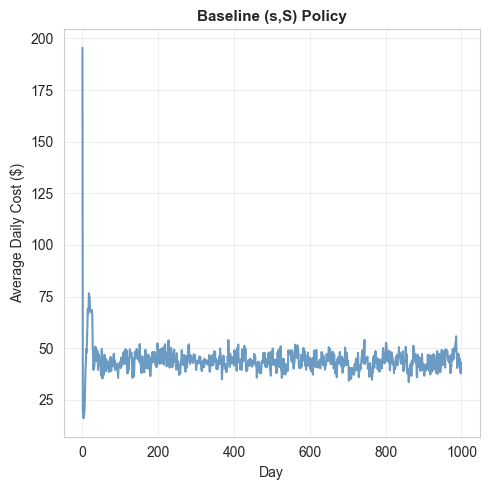

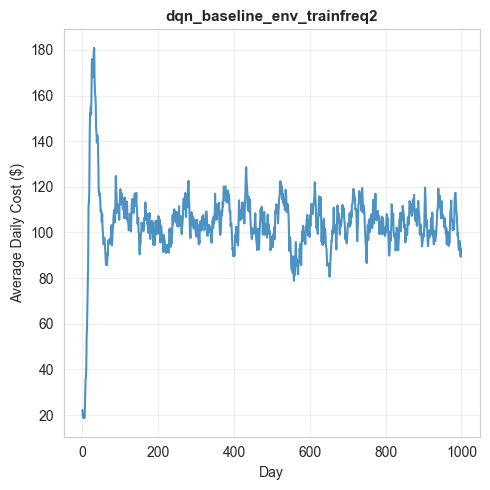

In [7]:
# Individual plots for detailed inspection
# Plot baseline
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(baseline_avg_daily, linewidth=1.5, alpha=0.8, color='steelblue')
ax.set_xlabel('Day', fontsize=10)
ax.set_ylabel('Average Daily Cost ($)', fontsize=10)
ax.set_title('Baseline (s,S) Policy', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot each RL agent separately
for agent_name in RL_AGENTS:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(rl_avg_daily[agent_name], linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Day', fontsize=10)
    ax.set_ylabel('Average Daily Cost ($)', fontsize=10)
    ax.set_title(agent_name, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### Individual Plots - Raw Costs

## 5. Apply Moving Average (Welch's Smoothing)

In [8]:
def compute_moving_average(data: list[float], window_size: int) -> list[float]:
    """
    Compute centered moving average.
    
    Args:
        data: Daily cost values
        window_size: Half-width of window (total window = 2*window_size + 1)
    
    Returns:
        Smoothed values
    """
    moving_avg = []
    
    for i in range(len(data) - window_size):
        if i < window_size:
            # Use expanding window at start
            moving_avg.append(sum(data[:2 * i + 1]) / (2 * i + 1))
        else:
            # Use full centered window
            window = data[i - window_size:i + window_size + 1]
            moving_avg.append(sum(window) / len(window))
    
    return moving_avg


# Apply smoothing
baseline_smoothed = compute_moving_average(baseline_avg_daily, WINDOW_SIZE)

rl_smoothed = {}
for agent_name in RL_AGENTS:
    rl_smoothed[agent_name] = compute_moving_average(rl_avg_daily[agent_name], WINDOW_SIZE)

print(f"✅ Applied moving average with window size {WINDOW_SIZE}")
print(f"   Baseline smoothed: {len(baseline_smoothed)} points")
for agent_name in RL_AGENTS:
    print(f"   {agent_name} smoothed: {len(rl_smoothed[agent_name])} points")

✅ Applied moving average with window size 25
   Baseline smoothed: 975 points
   dqn_baseline_env_trainfreq2 smoothed: 975 points


## 6. Plot Smoothed Curves (Welch Procedure)

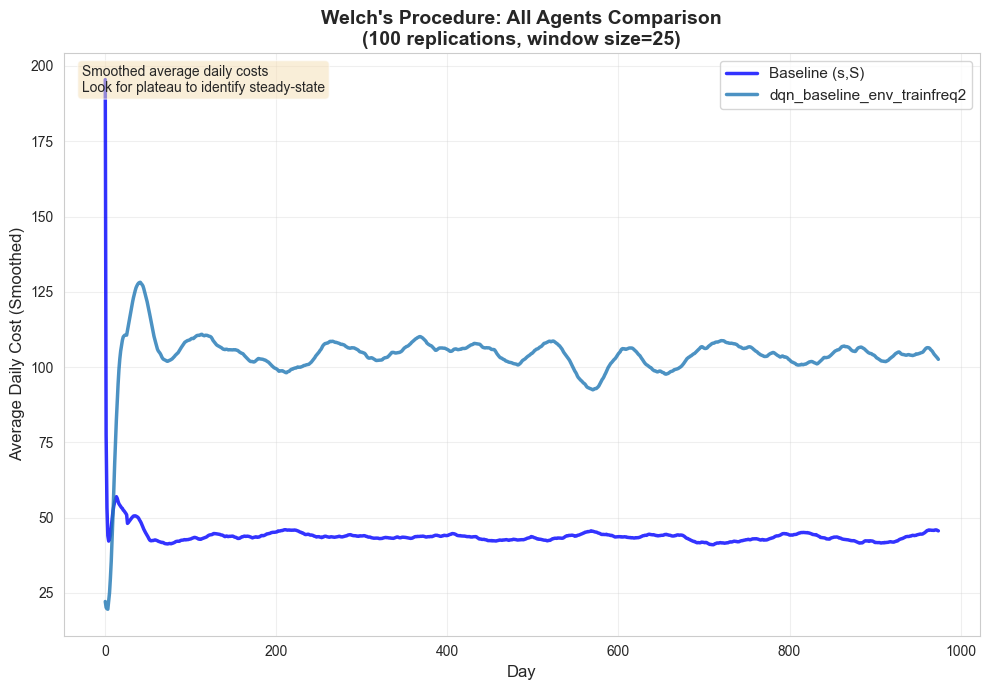

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))

# Plot baseline
ax.plot(baseline_smoothed, label='Baseline (s,S)', linewidth=2.5, alpha=0.8, color='blue')

# Plot RL agents
for agent_name in RL_AGENTS:
    ax.plot(rl_smoothed[agent_name], label=agent_name, linewidth=2.5, alpha=0.8)

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Average Daily Cost (Smoothed)', fontsize=12)
ax.set_title(
    f"Welch's Procedure: All Agents Comparison\n"
    f"({NUM_REPLICATIONS} replications, window size={WINDOW_SIZE})",
    fontsize=14, fontweight='bold'
)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

# Add annotation
ax.text(
    0.02, 0.98, 
    "Smoothed average daily costs\n"
    "Look for plateau to identify steady-state",
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

plt.tight_layout()
plt.show()

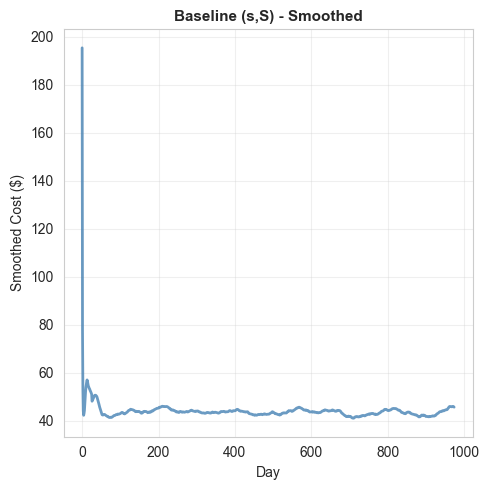

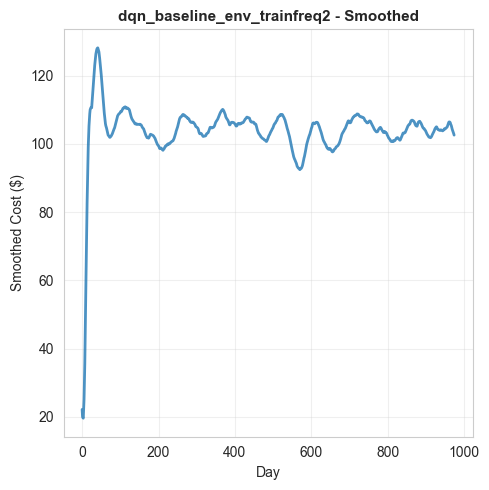

In [10]:
# Individual smoothed plots for detailed inspection
# Plot baseline
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(baseline_smoothed, linewidth=2, alpha=0.8, color='steelblue')
ax.set_xlabel('Day', fontsize=10)
ax.set_ylabel('Smoothed Cost ($)', fontsize=10)
ax.set_title('Baseline (s,S) - Smoothed', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot each RL agent separately
for agent_name in RL_AGENTS:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(rl_smoothed[agent_name], linewidth=2, alpha=0.8)
    ax.set_xlabel('Day', fontsize=10)
    ax.set_ylabel('Smoothed Cost ($)', fontsize=10)
    ax.set_title(f'{agent_name} - Smoothed', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### Individual Plots - Smoothed Curves

## 7. Automatic Warmup Detection

Use 5% tolerance algorithm to automatically detect warmup length.

In [11]:
def detect_warmup_length(smoothed_data: list[float], tolerance: float = 0.05) -> int:
    """
    Automatically detect warmup length using plateau detection.
    
    Args:
        smoothed_data: Smoothed daily cost curve
        tolerance: Relative tolerance for plateau (default: 5%)
    
    Returns:
        Warmup length in days
    """
    if len(smoothed_data) < 100:
        return len(smoothed_data) // 2
    
    # Use second half as steady-state estimate
    steady_state_start = len(smoothed_data) // 2
    steady_state_mean = np.mean(smoothed_data[steady_state_start:])
    threshold = tolerance * steady_state_mean
    
    # Find first point where cost stays within tolerance
    for i in range(50, len(smoothed_data) - 50):
        window = smoothed_data[i:i+50]
        if all(abs(val - steady_state_mean) <= threshold for val in window):
            return i
    
    # Fallback
    return len(smoothed_data) // 2


# Detect warmup for all policies
baseline_warmup = detect_warmup_length(baseline_smoothed)

rl_warmups = {}
for agent_name in RL_AGENTS:
    rl_warmups[agent_name] = detect_warmup_length(rl_smoothed[agent_name])

print("🔍 Detected Warmup Lengths:")
print(f"   Baseline (s,S): {baseline_warmup} days")
for agent_name in RL_AGENTS:
    print(f"   {agent_name}: {rl_warmups[agent_name]} days")

🔍 Detected Warmup Lengths:
   Baseline (s,S): 50 days
   dqn_baseline_env_trainfreq2: 127 days


## 8. Plot with Detected Warmup Periods

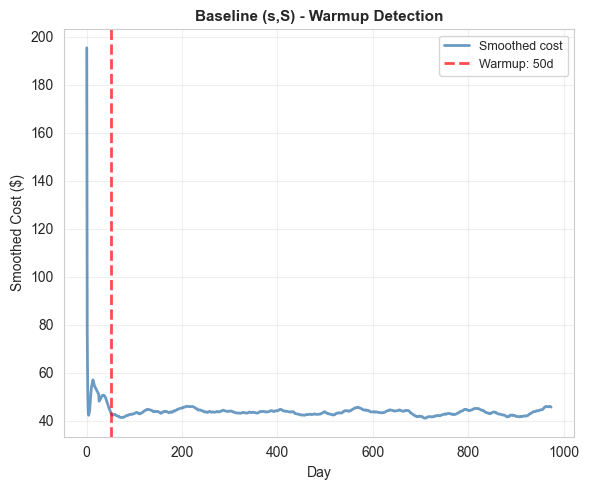

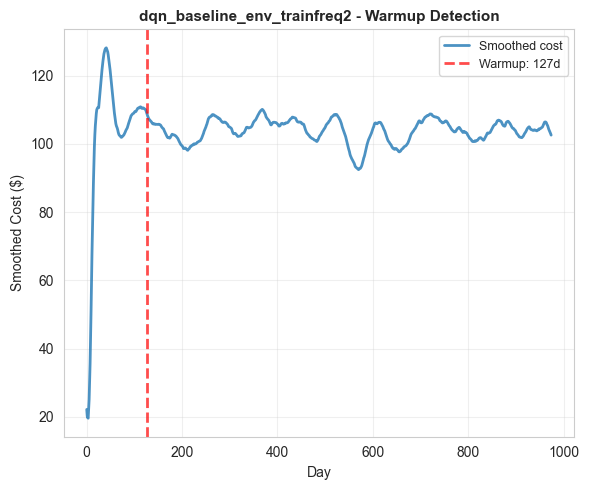

In [12]:
# Plot baseline with warmup
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(baseline_smoothed, linewidth=2, alpha=0.8, color='steelblue', label='Smoothed cost')
ax.axvline(baseline_warmup, color='red', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Warmup: {baseline_warmup}d')
ax.set_xlabel('Day', fontsize=10)
ax.set_ylabel('Smoothed Cost ($)', fontsize=10)
ax.set_title('Baseline (s,S) - Warmup Detection', fontsize=11, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot each RL agent with warmup separately
cmap = plt.colormaps.get_cmap('tab10')
for idx, agent_name in enumerate(RL_AGENTS):
    fig, ax = plt.subplots(figsize=(6, 5))
    color = cmap(idx / max(len(RL_AGENTS), 1))
    ax.plot(rl_smoothed[agent_name], linewidth=2, alpha=0.8, 
            color=color, label='Smoothed cost')
    ax.axvline(rl_warmups[agent_name], color='red', linestyle='--', 
               linewidth=2, alpha=0.7, 
               label=f'Warmup: {rl_warmups[agent_name]}d')
    ax.set_xlabel('Day', fontsize=10)
    ax.set_ylabel('Smoothed Cost ($)', fontsize=10)
    ax.set_title(f'{agent_name} - Warmup Detection', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### Individual Plots - Warmup Detection

## 9. Steady-State Cost Comparison

Compare performance after excluding warmup period.

In [13]:
# Compute steady-state metrics (excluding warmup)
def compute_steady_state_metrics(costs_data: list[list[float]], warmup: int) -> dict:
    """
    Compute steady-state cost metrics.
    
    Args:
        costs_data: [[day1, day2, ...], ...] for all replications
        warmup: Warmup period to exclude
    
    Returns:
        Dictionary with mean, std, ci_95
    """
    # Extract steady-state costs (after warmup) for each replication
    steady_state_costs = [np.mean(replication[warmup:]) 
                          for replication in costs_data]
    
    mean = np.mean(steady_state_costs)
    std = np.std(steady_state_costs)
    ci_95 = 1.96 * std / np.sqrt(len(steady_state_costs))
    
    return {
        'mean': mean,
        'std': std,
        'ci_95': ci_95,
        'per_replication': steady_state_costs,
    }


# Compute metrics
baseline_metrics = compute_steady_state_metrics(baseline_costs, baseline_warmup)

rl_metrics = {}
for agent_name in RL_AGENTS:
    rl_metrics[agent_name] = compute_steady_state_metrics(
        rl_agent_costs[agent_name], 
        rl_warmups[agent_name]
    )

# Print results
print("="*80)
print("STEADY-STATE COST COMPARISON")
print("="*80)

print(f"\nBaseline (s,S) Policy (warmup: {baseline_warmup} days):")
print(f"   Mean: ${baseline_metrics['mean']:.2f}")
print(f"   Std:  ${baseline_metrics['std']:.2f}")
print(f"   95% CI: ±${baseline_metrics['ci_95']:.2f}")

for agent_name in RL_AGENTS:
    metrics = rl_metrics[agent_name]
    improvement = ((baseline_metrics['mean'] - metrics['mean']) / baseline_metrics['mean']) * 100
    
    print(f"\n{agent_name} (warmup: {rl_warmups[agent_name]} days):")
    print(f"   Mean: ${metrics['mean']:.2f}")
    print(f"   Std:  ${metrics['std']:.2f}")
    print(f"   95% CI: ±${metrics['ci_95']:.2f}")
    print(f"   vs Baseline: {improvement:+.2f}%")

STEADY-STATE COST COMPARISON

Baseline (s,S) Policy (warmup: 50 days):
   Mean: $43.51
   Std:  $2.76
   95% CI: ±$0.54

dqn_baseline_env_trainfreq2 (warmup: 127 days):
   Mean: $103.85
   Std:  $6.84
   95% CI: ±$1.34
   vs Baseline: -138.68%


## 10. Visualization: Cost Comparison

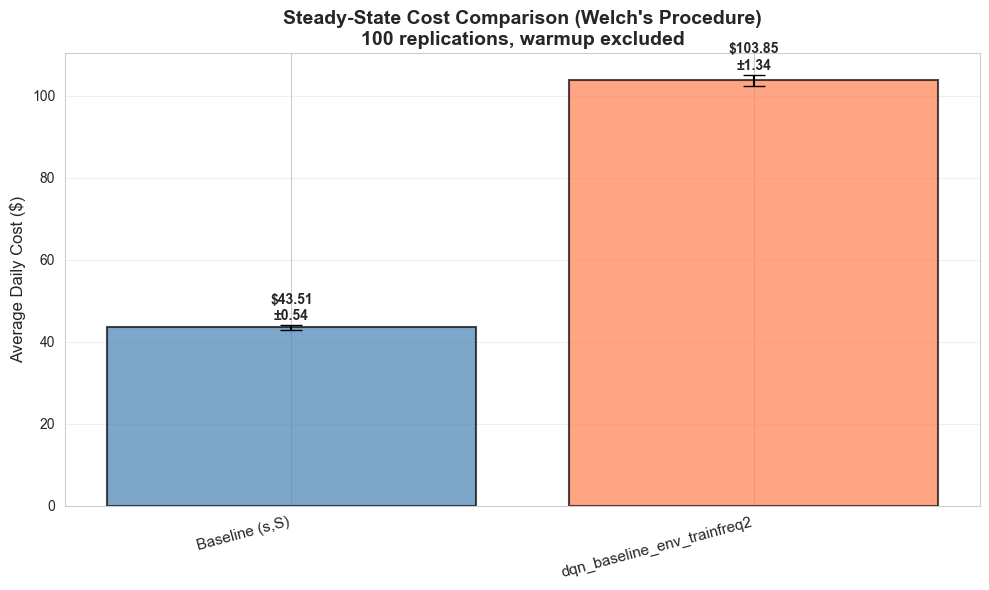

In [14]:
# Prepare data for visualization
policies = ['Baseline (s,S)'] + RL_AGENTS
means = [baseline_metrics['mean']] + [rl_metrics[name]['mean'] for name in RL_AGENTS]
cis = [baseline_metrics['ci_95']] + [rl_metrics[name]['ci_95'] for name in RL_AGENTS]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['steelblue'] + ['coral'] * len(RL_AGENTS)
bars = ax.bar(range(len(policies)), means, yerr=cis, 
              capsize=8, alpha=0.7, color=colors, edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(policies)))
ax.set_xticklabels(policies, fontsize=11, rotation=15, ha='right')
ax.set_ylabel('Average Daily Cost ($)', fontsize=12)
ax.set_title(
    'Steady-State Cost Comparison (Welch\'s Procedure)\n'
    f'{NUM_REPLICATIONS} replications, warmup excluded',
    fontsize=14, fontweight='bold'
)

# Add value labels on bars
for i, (mean, ci) in enumerate(zip(means, cis)):
    ax.text(i, mean + ci + 0.5, f'${mean:.2f}\n±{ci:.2f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 11. Export Results

In [15]:
# Prepare export data
export_data = {
    'configuration': {
        'sim_days': SIM_DAYS,
        'num_replications': NUM_REPLICATIONS,
        'window_size': WINDOW_SIZE,
        'k': K,
        'Q_max': Q_MAX,
        'seeds': [int(s) for s in WELCH_SEEDS],
    },
    'baseline': {
        'warmup_days': int(baseline_warmup),
        'steady_state_mean': float(baseline_metrics['mean']),
        'steady_state_std': float(baseline_metrics['std']),
        'steady_state_ci_95': float(baseline_metrics['ci_95']),
    },
    'rl_agents': {},
}

for agent_name in RL_AGENTS:
    export_data['rl_agents'][agent_name] = {
        'warmup_days': int(rl_warmups[agent_name]),
        'steady_state_mean': float(rl_metrics[agent_name]['mean']),
        'steady_state_std': float(rl_metrics[agent_name]['std']),
        'steady_state_ci_95': float(rl_metrics[agent_name]['ci_95']),
        'improvement_vs_baseline': float(
            ((baseline_metrics['mean'] - rl_metrics[agent_name]['mean']) / 
             baseline_metrics['mean']) * 100
        ),
    }

# Save to JSON
import json
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

output_path = results_dir / "welch_procedure_results.json"
with open(output_path, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"✅ Results saved to: {output_path}")
print(f"\n📊 Summary exported:")
print(f"   • {NUM_REPLICATIONS} replications × {SIM_DAYS} days")
print(f"   • Warmup periods detected automatically")
print(f"   • Steady-state metrics for baseline + {len(RL_AGENTS)} RL agents")

✅ Results saved to: ../results/welch_procedure_results.json

📊 Summary exported:
   • 100 replications × 1000 days
   • Warmup periods detected automatically
   • Steady-state metrics for baseline + 1 RL agents
